# Using MLJ to classifiy the MNIST image dataset

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using MLJ
using Flux
import MLJFlux
using Random
Random.seed!(123)

MLJ.color_off()

using Plots
pyplot(size=(600, 300*(sqrt(5)-1)));

 Activating environment at `~/Dropbox/Julia7/MLJ/MLJFlux/examples/mnist/Project.toml`


## Basic training

Downloading the MNIST image dataset:

In [2]:
import Flux.Data.MNIST
images, labels = MNIST.images(), MNIST.labels();

In MLJ, integers cannot be used for encoding categorical data, so we
must force the labels to have the `Multiclass` [scientific
type](https://alan-turing-institute.github.io/MLJScientificTypes.jl/dev/). For
more on this, see [Working with Categorical
Data](https://alan-turing-institute.github.io/MLJ.jl/dev/working_with_categorical_data/).

In [3]:
labels = coerce(labels, Multiclass);

Checking scientific types:

In [4]:
@assert scitype(images) <: AbstractVector{<:Image}
@assert scitype(labels) <: AbstractVector{<:Finite}

Looks good.

For general instructions on coercing image data, see [Type coercion
for image
data](https://alan-turing-institute.github.io/MLJScientificTypes.jl/dev/#Type-coercion-for-image-data-1)

In [5]:
images[1]

We start by defining a suitable `Builder` object. This is a recipe
for building the neural network. Our builder will work for images of
any (constant) size, whether they be color or black and white (ie,
single or multi-channel).  The architecture always consists of six
alternating convolution and max-pool layers, and a final dense
layer; the filter size and the number of channels after each
convolution layer is customisable.

In [6]:
import MLJFlux
mutable struct MyConvBuilder
    filter_size::Int
    channels1::Int
    channels2::Int
    channels3::Int
end

flatten(x::AbstractArray) = reshape(x, :, size(x)[end])
half(x) = div(x, 2)

function MLJFlux.build(b::MyConvBuilder, n_in, n_out, n_channels)

    k, c1, c2, c3 = b.filter_size, b.channels1, b.channels2, b.channels3

    mod(k, 2) == 1 || error("`filter_size` must be odd. ")

    p = div(k - 1, 2) # padding to preserve image size on convolution:

    h = n_in[1] |> half |> half |> half # final "image" height
    w = n_in[2] |> half |> half |> half # final "image" width

    return Chain(
        Conv((k, k), n_channels => c1, pad=(p, p), relu),
        MaxPool((2, 2)),
        Conv((k, k), c1 => c2, pad=(p, p), relu),
        MaxPool((2, 2)),
        Conv((k, k), c2 => c3, pad=(p, p), relu),
        MaxPool((2 ,2)),
        flatten,
        Dense(h*w*c3, n_out))
end

**Note.** There is no final `softmax` here, as this is applied by
default in all MLJFLux classifiers. Customisation of this behaviour
is controlled using using the `finaliser` hyperparameter of the
classifier.

We now define the MLJ model. If you have a GPU, substitute
`acceleration=CUDALibs()` below:

In [7]:
ImageClassifier = @load ImageClassifier
clf = ImageClassifier(builder=MyConvBuilder(3, 16, 32, 32),
                      acceleration=CPU1(),
                      batch_size=50,
                      epochs=10)

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main.##406 /Users/anthony/.julia/packages/MLJModels/66QJr/src/loading.jl:168
import MLJFlux ✔


ImageClassifier(
    builder = Main.##406.MyConvBuilder(3, 16, 32, 32),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.Losses.crossentropy,
    epochs = 10,
    batch_size = 50,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false,
    acceleration = CPU1{Nothing}(nothing)) @610

You can add Flux options `optimiser=...` and `loss=...` here. At
present, `loss` must be a Flux-compatible loss, not an MLJ measure.

Binding the model with data in an MLJ machine:

In [8]:
mach = machine(clf, images, labels);

Training for 10 epochs on the first 500 images:

In [9]:
fit!(mach, rows=1:500, verbosity=2);

┌ Info: Training Machine{ImageClassifier{MyConvBuilder,…},…} @309.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/4DmTL/src/machines.jl:341
┌ Info: Loss is 2.239
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/wj7HX/src/core.jl:122
┌ Info: Loss is 2.109
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/wj7HX/src/core.jl:122
┌ Info: Loss is 1.814
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/wj7HX/src/core.jl:122
┌ Info: Loss is 1.269
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/wj7HX/src/core.jl:122
┌ Info: Loss is 0.7602
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/wj7HX/src/core.jl:122
┌ Info: Loss is 0.5445
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/wj7HX/src/core.jl:122
┌ Info: Loss is 0.4606
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/wj7HX/src/core.jl:122
┌ Info: Loss is 0.341
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/wj7HX/src/core.jl:122
┌ Info: Loss is 0.2975
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/wj7HX/src/core.jl:1

Inspecting:

In [10]:
report(mach)

(training_losses = Float32[2.3228688, 2.2390091, 2.1091332, 1.8143247, 1.2688795, 0.7602044, 0.5444913, 0.46060604, 0.34104377, 0.29750612, 0.25796312],)

In [11]:
chain = fitted_params(mach)

(chain = Chain(Chain(Conv((3, 3), 1=>16, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 16=>32, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 32=>32, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), flatten, Dense(288, 10)), softmax),)

In [12]:
Flux.params(chain)[2]

16-element Array{Float32,1}:
  0.009390039
  0.07259901
 -0.0038282378
  0.016712788
  0.0019806586
  0.027747802
 -0.0007373232
  0.00018299253
  0.07081616
  0.06927007
  0.0020753173
  0.0032080673
  0.015448462
  0.008061458
  0.02398603
  0.047106728

Adding 20 more epochs:

In [13]:
clf.epochs = clf.epochs + 20
fit!(mach, rows=1:500);

┌ Info: Updating Machine{ImageClassifier{MyConvBuilder,…},…} @309.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/4DmTL/src/machines.jl:342
Optimising neural net:100%[=========================] Time: 0:00:13


Computing an out-of-sample estimate of the loss:

In [14]:
predicted_labels = predict(mach, rows=501:1000);
cross_entropy(predicted_labels, labels[501:1000]) |> mean

0.3694199f0

Or, in one line (after resetting the RNG seed to ensure the same
result):

In [15]:
Random.seed!(123)
evaluate!(mach,
          resampling=Holdout(fraction_train=0.5),
          measure=cross_entropy,
          rows=1:1000,
          verbosity=0)

┌───────────────────────┬───────────────┬────────────────┐
│ _.measure             │ _.measurement │ _.per_fold     │
├───────────────────────┼───────────────┼────────────────┤
│ LogLoss{Float64} @457 │ 0.366         │ Float32[0.366] │
└───────────────────────┴───────────────┴────────────────┘
_.per_observation = [[[6.14, 0.186, ..., 0.000432]]]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


## Using out-of-sample loss estimates to terminate training:

MLJ will eventually provide model wrappers for controlling iterative
models. In the meantime some control can be implememted using the
[EarlyStopping.jl](https://github.com/ablaom/EarlyStopping.jl)
package, and without the usual need for callbacks.

Defining an `EarlyStopper` object combining three separate stopping
critera:

In [16]:
using EarlyStopping
stopper = EarlyStopper(NotANumber(), Patience(3), UP())

losses = Float32[]
training_losses = Float32[];

Resetting the number of epochs to zero:

In [17]:
clf.epochs = 0;

Defining a function to increment the number of epochs, re-evaluate,
and test for early stopping:

In [18]:
function done()
    clf.epochs = clf.epochs + 1
    e = evaluate!(mach,
                  resampling=Holdout(fraction_train=0.5),
                  measure=cross_entropy,
                  rows=1:1000,
                  verbosity=0)
    loss = e.measurement[1][1]
    push!(losses, loss)
    training_loss = report(mach).training_losses[end]
    push!(training_losses, training_loss)
    println("out-of-sample loss: $loss")
    return done!(stopper, loss)
end;

**Note.** Each time the number of epochs is increased and
`evaluate!` is called, warm-start training is used (assuming
`resampling isa Holdout`). This is because MLJ machines cache
hyper-parameters and learned parameters to avoid unnecessary
retraining. In other frameworks the same behaviour is implemented
using callbacks, but we don't need this here.

In [19]:
while !done() end
message(stopper)

out-of-sample loss: 2.2431312
out-of-sample loss: 2.0029933
out-of-sample loss: 1.7959844
out-of-sample loss: 1.244554
out-of-sample loss: 0.94218606
out-of-sample loss: 0.7539173
out-of-sample loss: 0.79375595
out-of-sample loss: 0.6361606
out-of-sample loss: 0.41542837
out-of-sample loss: 0.46413818
out-of-sample loss: 0.42553732
out-of-sample loss: 0.39613354
out-of-sample loss: 0.45188573
out-of-sample loss: 0.4788511
out-of-sample loss: 0.2794475
out-of-sample loss: 0.34474075
out-of-sample loss: 0.31935462
out-of-sample loss: 0.35703415
out-of-sample loss: 0.33456266
out-of-sample loss: 0.3544311
out-of-sample loss: 0.36802253
out-of-sample loss: 0.32795852
out-of-sample loss: 0.34665957
out-of-sample loss: 0.34711397
out-of-sample loss: 0.4421464


"Early stop triggered by Patience(3) stopping criterion. "

A comparison of the training and out-of-sample losses:

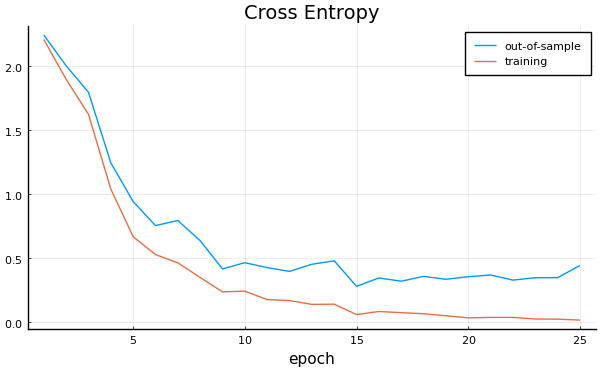

In [20]:
plot(losses,
     title="Cross Entropy",
     xlab = "epoch",
     label="out-of-sample")
plot!(training_losses, label="training")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*